In [2]:
#libraries
import numpy as np 
import pandas as pd 
import os
import json
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import time
import datetime
from PIL import Image
import gc
from tqdm import tqdm_notebook
import random
import warnings
warnings.filterwarnings("ignore")
from functools import partial
pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 100)
from collections import Counter
from IPython.display import display 

In [3]:
train = pd.read_csv('../data/petfinder/train.csv')
breeds = pd.read_csv('../data/petfinder/breed_labels.csv')
colors = pd.read_csv('../data/petfinder/color_labels.csv')
states = pd.read_csv('../data/petfinder/state_labels.csv')

all_data = pd.concat([train])

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type           14993 non-null  int64  
 1   Name           13736 non-null  object 
 2   Age            14993 non-null  int64  
 3   Breed1         14993 non-null  int64  
 4   Breed2         14993 non-null  int64  
 5   Gender         14993 non-null  int64  
 6   Color1         14993 non-null  int64  
 7   Color2         14993 non-null  int64  
 8   Color3         14993 non-null  int64  
 9   MaturitySize   14993 non-null  int64  
 10  FurLength      14993 non-null  int64  
 11  Vaccinated     14993 non-null  int64  
 12  Dewormed       14993 non-null  int64  
 13  Sterilized     14993 non-null  int64  
 14  Health         14993 non-null  int64  
 15  Quantity       14993 non-null  int64  
 16  Fee            14993 non-null  int64  
 17  State          14993 non-null  int64  
 18  Rescue

In [24]:
train.drop('Description', axis=1).head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,PetID,PhotoAmt,AdoptionSpeed,dataset_type
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,86e1089a3,1.0,2,train
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,6296e909a,2.0,0,train
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,3422e4906,7.0,3,train
3,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,5842f1ff5,8.0,2,train
4,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,850a43f90,3.0,2,train


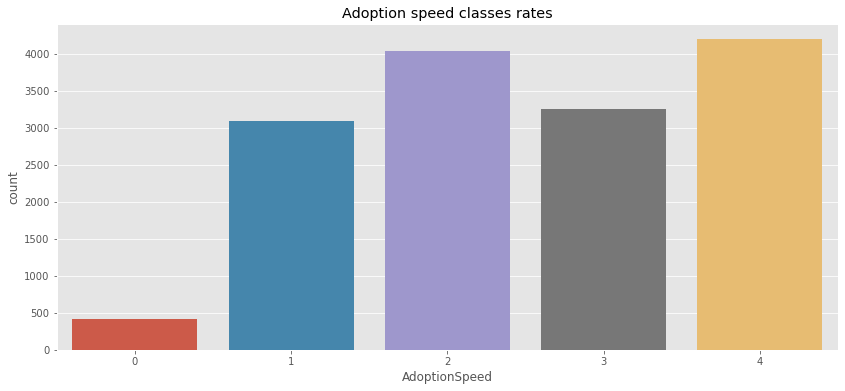

In [25]:
plt.figure(figsize=(14, 6));
g = sns.countplot(x='AdoptionSpeed', data=all_data.loc[all_data['dataset_type'] == 'train']);
plt.title('Adoption speed classes rates');
ax=g.axes

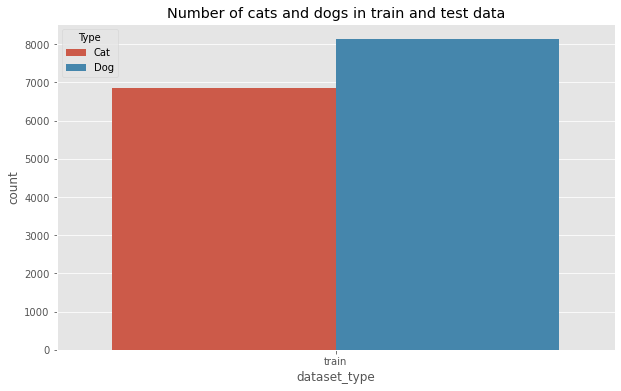

In [26]:
all_data['Type'] = all_data['Type'].apply(lambda x: 'Dog' if x == 1 else 'Cat')
plt.figure(figsize=(10, 6));
sns.countplot(x='dataset_type', data=all_data, hue='Type');
plt.title('Number of cats and dogs in train and test data');

In [27]:
main_count = train['AdoptionSpeed'].value_counts(normalize=True).sort_index()
def prepare_plot_dict(df, col, main_count):
    """
    Preparing dictionary with data for plotting.
    
    I want to show how much higher/lower are the rates of Adoption speed for the current column comparing to base values (as described higher),
    At first I calculate base rates, then for each category in the column I calculate rates of Adoption speed and find difference with the base rates.
    
    """
    main_count = dict(main_count)
    plot_dict = {}
    for i in df[col].unique():
        val_count = dict(df.loc[df[col] == i, 'AdoptionSpeed'].value_counts().sort_index())

        for k, v in main_count.items():
            if k in val_count:
                plot_dict[val_count[k]] = ((val_count[k] / sum(val_count.values())) / main_count[k]) * 100 - 100
            else:
                plot_dict[0] = 0

    return plot_dict

def make_count_plot(df, x, hue='AdoptionSpeed', title='', main_count=main_count):
    """
    Plotting countplot with correct annotations.
    """
    g = sns.countplot(x=x, data=df, hue=hue);
    plt.title(f'AdoptionSpeed {title}');
    ax = g.axes

    plot_dict = prepare_plot_dict(df, x, main_count)

    for p in ax.patches:
        h = p.get_height() if str(p.get_height()) != 'nan' else 0
        text = f"{plot_dict[h]:.0f}%" if plot_dict[h] < 0 else f"+{plot_dict[h]:.0f}%"
        ax.annotate(text, (p.get_x() + p.get_width() / 2., h),
             ha='center', va='center', fontsize=11, color='green' if plot_dict[h] > 0 else 'red', rotation=0, xytext=(0, 10),
             textcoords='offset points')  

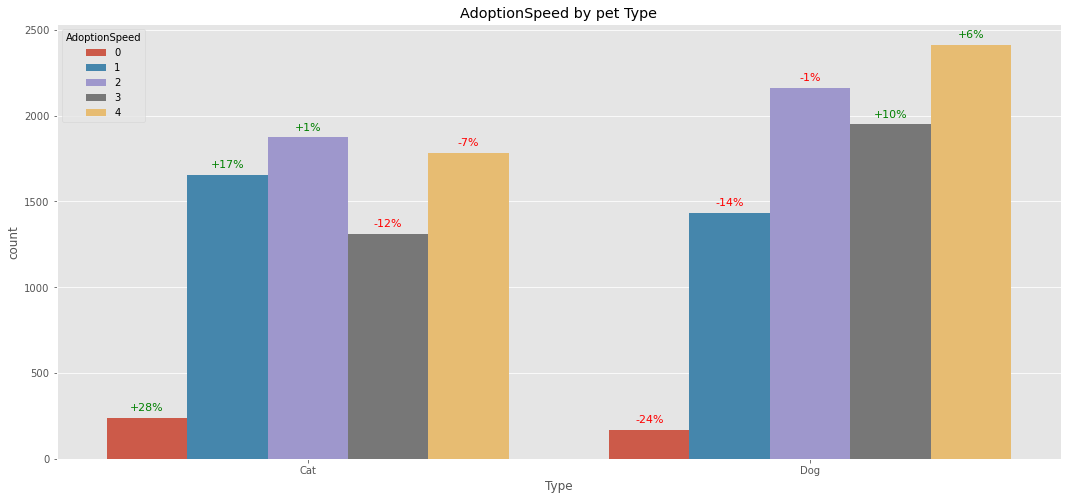

In [28]:
plt.figure(figsize=(18, 8));
make_count_plot(df=all_data.loc[all_data['dataset_type'] == 'train'], x='Type', title='by pet Type')

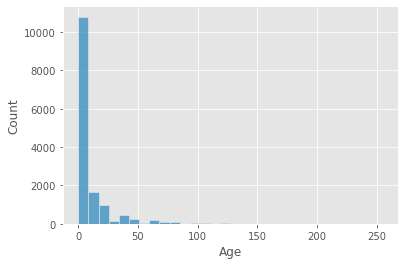

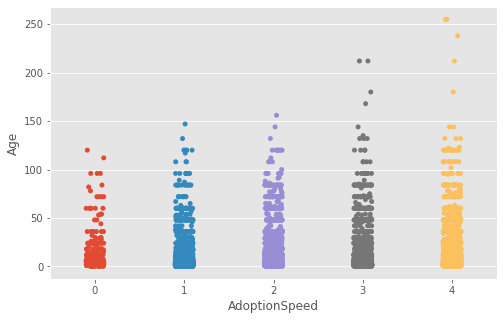

In [65]:
sns.histplot(data=train, x="Age", bins=30)
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.stripplot(x="AdoptionSpeed", y="Age", data=train, ax=ax)

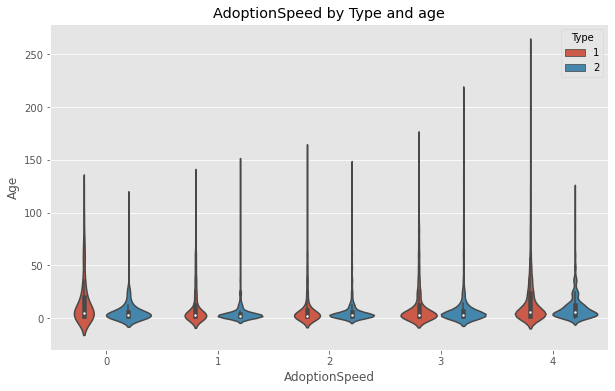

In [35]:
plt.figure(figsize=(10, 6));
sns.violinplot(x="AdoptionSpeed", y="Age", hue="Type", data=train);
plt.title('AdoptionSpeed by Type and age');

In [45]:
train['Pure_breed'] = 0
train.loc[train['Breed2'] == 0, 'Pure_breed'] = 1
all_data['Pure_breed'] = 0
all_data.loc[all_data['Breed2'] == 0, 'Pure_breed'] = 1

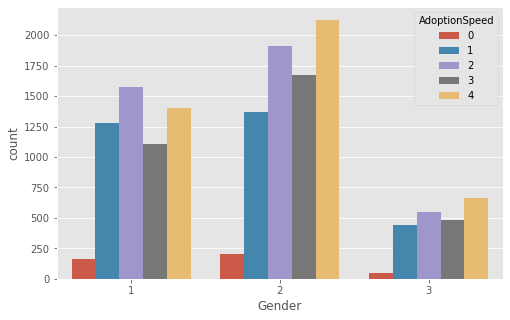

In [67]:
## Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.countplot(x="Gender", data=train, ax=ax, hue="AdoptionSpeed")

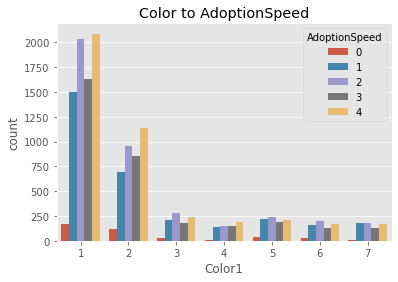

In [56]:
## Color1 (1 = Black, 2 = Brown, 3 = Golden, 4 = Yellow, 5 = Cream, 6 = Gray, 7 = White )
fig, ax = plt.subplots()
sns.countplot(x="Color1", data=train, hue="AdoptionSpeed", ax=ax)
g = ax.set_title("Color to AdoptionSpeed")

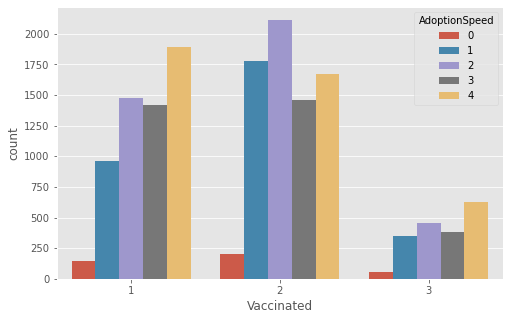

In [68]:
## vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.countplot(x="Vaccinated", data=train, hue="AdoptionSpeed", ax=ax)

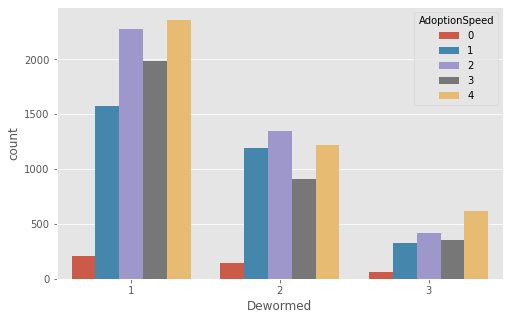

In [69]:
## dewormed (1 = Yes, 2 = No, 3 = Not Sure)
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.countplot(x="Dewormed", data=train, hue="AdoptionSpeed", ax=ax)

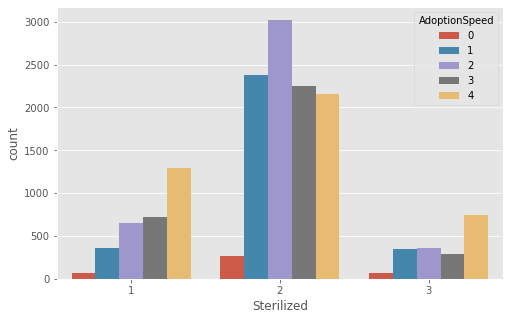

In [70]:
## spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.countplot(x="Sterilized", data=train, hue="AdoptionSpeed", ax=ax)

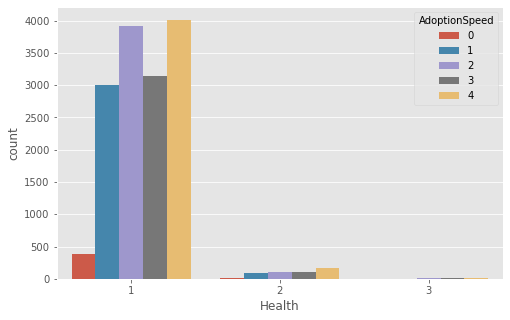

In [71]:
## Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.countplot(x="Health", data=train, hue="AdoptionSpeed", ax=ax)

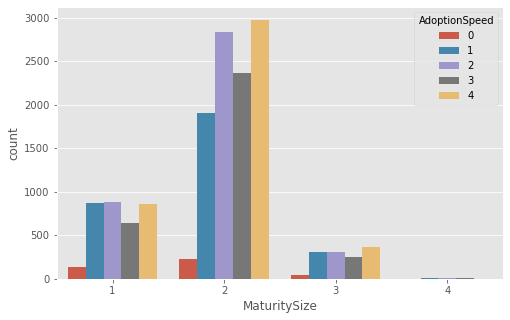

In [73]:
## maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.countplot(x="MaturitySize", data=train, hue="AdoptionSpeed", ax=ax)

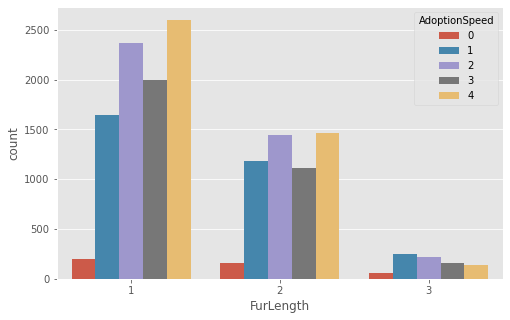

In [72]:
## Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.countplot(x="FurLength", data=train, hue="AdoptionSpeed", ax=ax)

Text(0.5, 1.0, 'Images on Pet profile to adoption speed')

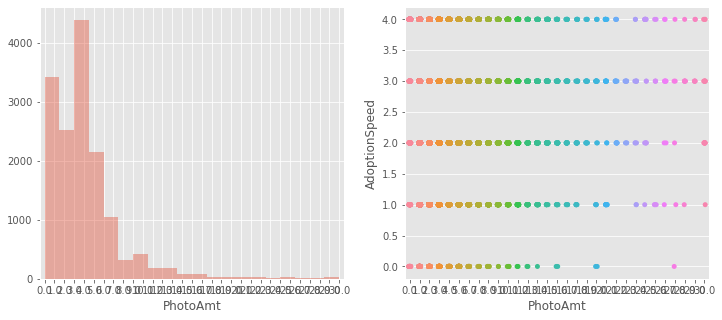

In [81]:
## 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
ax1 = sns.distplot(train.PhotoAmt, kde=False, bins=20, ax=ax1)
ax.set_title("Images on Pet profile", fontsize=15)
ax2 = sns.stripplot(x="PhotoAmt", y="AdoptionSpeed", data=train, ax=ax2)
ax.set_title("Images on Pet profile to adoption speed", fontsize=15)

Text(0.5, 1.0, 'Fee on Pet adoption to adoption speed')

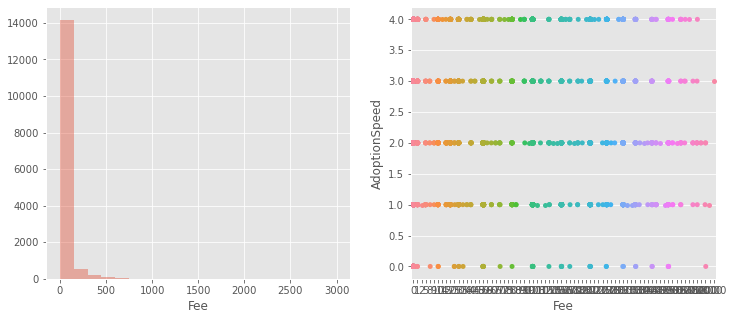

In [83]:
## 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1 = sns.distplot(train.Fee, kde=False, bins=20, ax=ax1)
ax.set_title("Fee on Pet adoption", fontsize=15)
ax2 = sns.stripplot(x="Fee", y="AdoptionSpeed", data=train, ax=ax2)
ax.set_title("Fee on Pet adoption to adoption speed", fontsize=15)

In [57]:
train.corr()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,VideoAmt,PhotoAmt,AdoptionSpeed,Pure_breed
Type,1.000000,-0.147162,0.057724,-0.043568,0.060843,0.097680,0.246333,0.201693,-0.171811,0.003036,0.102907,0.025508,0.006737,-0.006864,0.036423,-0.042134,0.124549,-0.005967,0.049368,-0.091240,0.062515
Age,-0.147162,1.000000,-0.314346,-0.041010,-0.123423,0.090378,-0.039427,-0.053546,0.093673,0.153092,-0.136061,-0.053360,-0.189450,0.103215,-0.113076,0.089168,0.024523,-0.015969,-0.084778,0.100510,0.022959
Breed1,0.057724,-0.314346,1.000000,-0.157053,0.071321,-0.035510,-0.007081,-0.000682,-0.010507,-0.108059,0.046518,0.013216,0.052698,-0.034893,0.090194,-0.189526,-0.026832,0.020626,0.043395,0.107834,0.178797
Breed2,-0.043568,-0.041010,-0.157053,1.000000,0.056907,-0.020324,0.003015,0.035679,0.049879,0.106220,0.005638,-0.009817,-0.005989,-0.029285,0.038125,0.013508,-0.037993,0.001569,0.045953,-0.018642,-0.959583
Gender,0.060843,-0.123423,0.071321,0.056907,1.000000,-0.115351,0.026507,0.259309,-0.091819,-0.030404,0.078702,0.091431,0.040645,-0.045177,0.494489,-0.050491,0.002564,0.016816,0.098435,0.057622,-0.050674
Color1,0.097680,0.090378,-0.035510,-0.020324,-0.115351,1.000000,-0.113290,-0.282897,-0.029468,0.066967,-0.017475,-0.019318,-0.037050,0.024410,-0.116688,0.054180,0.024012,-0.006435,-0.041323,-0.044192,0.023420
Color2,0.246333,-0.039427,-0.007081,0.003015,0.026507,-0.113290,1.000000,0.088742,-0.065155,-0.008764,0.026193,0.005812,0.007370,-0.004307,0.019876,-0.017308,0.026944,0.023983,0.059113,-0.038579,-0.005305
Color3,0.201693,-0.053546,-0.000682,0.035679,0.259309,-0.282897,0.088742,1.000000,-0.051730,0.013581,0.054053,0.048617,0.038899,-0.024782,0.272548,-0.019839,0.010554,0.019526,0.103662,-0.007014,-0.036414
MaturitySize,-0.171811,0.093673,-0.010507,0.049879,-0.091819,-0.029468,-0.065155,-0.051730,1.000000,0.095142,-0.087722,-0.067352,-0.066321,-0.012957,-0.042832,0.041144,-0.062584,0.017032,0.015593,0.045653,-0.056760
FurLength,0.003036,0.153092,-0.108059,0.106220,-0.030404,0.066967,-0.008764,0.013581,0.095142,1.000000,-0.006010,0.016463,0.032092,0.028096,-0.038388,0.159693,-0.029317,-0.014740,-0.031557,-0.091337,-0.120493


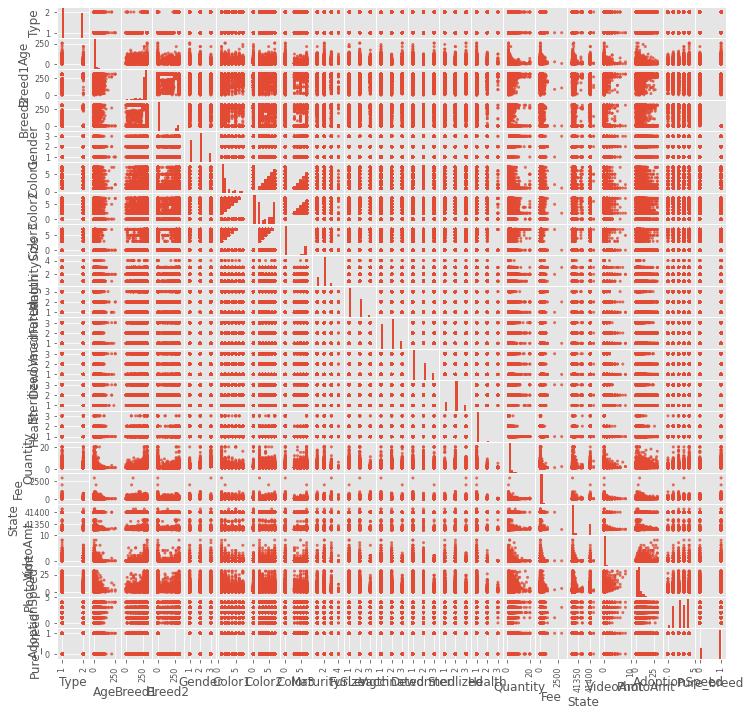

In [59]:
g = pd.plotting.scatter_matrix(train, alpha=0.8, figsize=(12,12), range_padding=0.5)

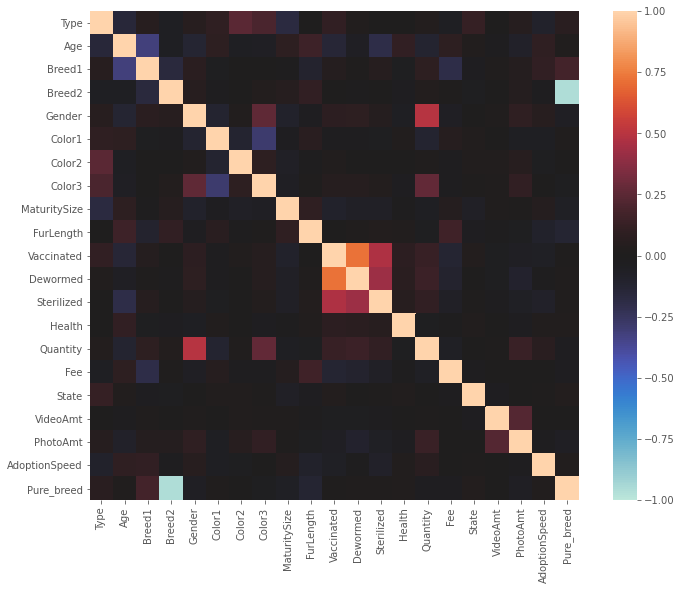

In [61]:
fig, ax = plt.subplots(figsize=(12, 9)) 
ax = sns.heatmap(train.corr(), square=True, vmax=1, vmin=-1, center=0)

0                     Nibble
1                No Name Yet
2                     Brisco
3                       Miko
4                     Hunter
5                        NaN
6                      BULAT
7    Siu Pak & Her 6 Puppies
8                        NaN
9                      Kitty
Name: Name, dtype: object
                    Name  AdoptionSpeed
56  Hitler (rename-able)              4
N/A name percentages:  0.08383912492496498
Average adoption speed for pets with a name: 2.5085905649388467
Average adoption speed for pets without a name: 2.602227525855211


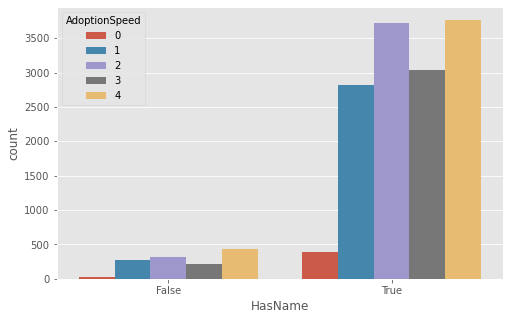

In [51]:
# Analyzing names of pets.
print(all_data.Name[:10])

print(all_data.loc[all_data['Name'] == "Hitler (rename-able)", ['Name', 'AdoptionSpeed']])

print("N/A name percentages: ", all_data.Name.isna().mean())
all_data['HasName'] = ~all_data.Name.isna()

all_data[['Name', 'HasName']].head(10)

print("Average adoption speed for pets with a name:",all_data.loc[all_data.Has_Name, 'AdoptionSpeed'].mean())
print("Average adoption speed for pets without a name:",all_data.loc[~all_data.Has_Name, 'AdoptionSpeed'].mean())

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.countplot(x="HasName", data=all_data, hue="AdoptionSpeed", ax=ax)

AdoptionSpeed
0    303.834146
1    337.009061
2    346.104038
3    367.291194
4    316.227543
Name: DescriptionLength, dtype: float64


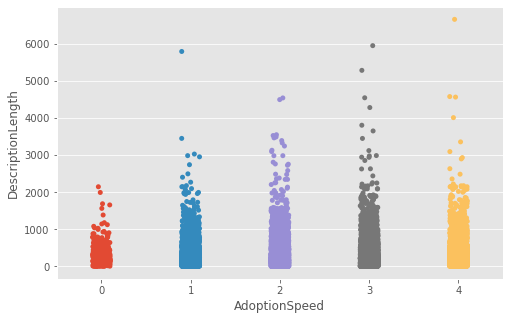

In [75]:
# Analyzing the lengths of the descriptions.

all_data = all_data.astype({'Description' : str})

all_data['DescriptionLength'] = all_data['Description'].apply(len)

print(all_data.groupby(['AdoptionSpeed'])['DescriptionLength'].mean())

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.stripplot(x="AdoptionSpeed", y="DescriptionLength", data=all_data, ax=ax)

In [85]:
# Get sentiment data.
def get_description_sentiment_dataframe():

    ids = []
    sentiment_magnitudes = []
    sentiment_scores = []
    
    path = '../data/petfinder/train_sentiment'
    fileList = os.listdir(path)
    
    for filename in fileList:
        file = open(os.path.join('../data/petfinder/train_sentiment/'+ filename), 'r', encoding="utf8")
        
        sentiment = json.load(file)
        
        id = filename.split(".")[0]
        sentiment_magnitude = float(sentiment['documentSentiment']['magnitude'])
        sentiment_score = float(sentiment['documentSentiment']['score'])
        
        ids.append(id)
        sentiment_magnitudes.append(sentiment_magnitude)
        sentiment_scores.append(sentiment_score)
        
    d = {"id": ids, "sentiment_magnitude": sentiment_magnitudes, "sentiment_score": sentiment_scores }
    df = pd.DataFrame(d)
    
    return df
        
sentiment_df = get_description_sentiment_dataframe()
sentiment_df.head(10)


,id,sentiment_magnitude,sentiment_score
0,0008c5398,2.8,0.7
1,000a290e4,0.6,0.3
2,000fb9572,0.8,0.3
3,0011d7c25,0.8,0.8
4,00156db4a,1.8,0.0
5,001a1aaad,3.5,0.2
6,001b1507c,4.7,0.3
7,002230dea,2.0,0.4
8,002278114,11.4,0.1
9,0038234c6,3.0,0.3


In [89]:
all_data_with_sentiment_df = all_data.merge(sentiment_df, left_on='PetID', right_on='id', how='left')

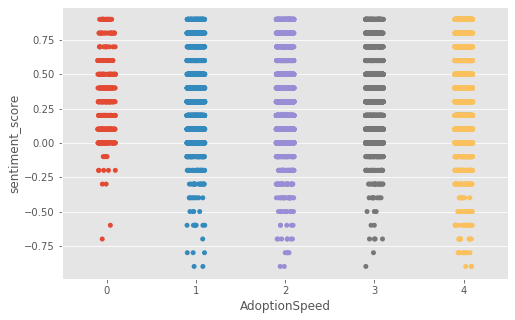

In [96]:
# Sentiment score for different adoption speeds.
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.stripplot(x="AdoptionSpeed", y="sentiment_score", data=all_data_with_sentiment_df, ax=ax)

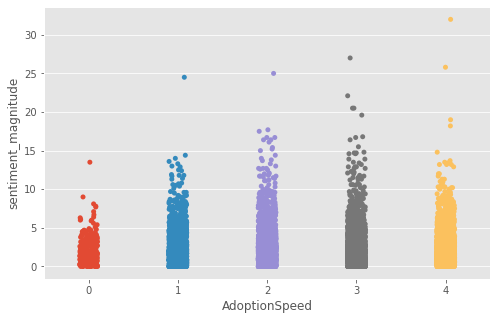

In [97]:
# Sentiment magnitudes for different adoption speeds.
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.stripplot(x="AdoptionSpeed", y="sentiment_magnitude", data=all_data_with_sentiment_df, ax=ax)

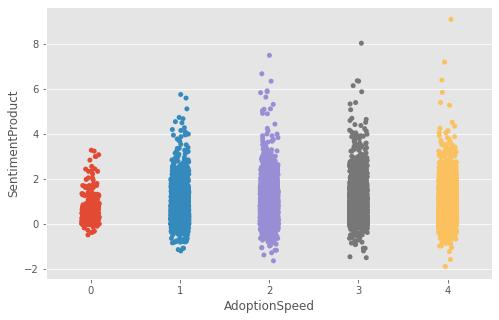

In [99]:
# Computing sentiment product to combine score and magnitude.
all_data_with_sentiment_df['SentimentProduct'] = all_data_with_sentiment_df['sentiment_score']*all_data_with_sentiment_df['sentiment_magnitude']

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.stripplot(x="AdoptionSpeed", y="SentimentProduct", data=all_data_with_sentiment_df, ax=ax)